In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import time
import random
import math
import tensorflow as tf
from skmultiflow.drift_detection import PageHinkley, ADWIN
from skmultiflow.data import DataStream
from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from tensorflow.keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr
from scipy.stats import entropy
from tensorflow import keras
from sklearn import preprocessing

In [2]:
def get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [3]:
def get_initial_model_2(inp, out):
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [4]:
def DP_get_initial_model(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [5]:
def DP_get_initial_model_2(inp, out): #get initial model
    model = tf.keras.Sequential([
        Dense(10, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(out, activation='softmax')
        ])
    #optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
def node_comparison1(node1, node2, epsilon=0.05): #this function is to see if the nodes are atmost epsilon distance apart
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(math.sqrt((x-y)*(x-y))<=epsilon):
            continue
        else:
            return False
  return True

In [7]:
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [8]:
def layer_comparison(layer1, layer2): #compare same layers in two different DNNs
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2)):
        present=True
    if present==False:
      return False
  return True

In [9]:
def check_models(Model_weights1, Model_weights2): # compare two deep neural networks based on their weights
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2)):
      continue
    else:
      return False
  return True

In [10]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    
    mean_size=len(models_weights)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [11]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights_2(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model_2(inp_shape, 6).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [12]:
# custom functions for f1, precision and recall

from keras import backend as K
from sklearn import preprocessing

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [13]:
# A function to check if the two samples are different:
def return_samples(Positive, Negative, data, N):
    datasets=[]
    positiveN=int((Positive.shape[0]/data.shape[0])*N)
    negativeN=int(N-positiveN)
    print(negativeN)
    while (Positive.empty==False and Negative.empty==False):
        df1=Positive.sample(min(positiveN, len(Positive)))
        Positive.drop(df1.index, inplace=True)
        """
        drop_df1=np.random.choice(df1.index,(int)(min(positiveN, math.ceil(len(Positive))/2)), replace=False)
        if len(Positive)<positiveN:
            Positive.drop(df1.index, inplace=True)
        else:
            Positive.drop(drop_df1, inplace=True)
        #print(len(Positive))
        """
        df2=Negative.sample(min(negativeN, len(Negative)))
        Negative.drop(df2.index, inplace=True)
        """
        drop_df2 = np.random.choice(df2.index,(int)(min(negativeN, math.ceil(len(Negative))/2)))
        if len(Negative)<negativeN:
            Negative.drop(df2.index, inplace = True)
        else:
            Negative.drop(drop_df2, inplace=True)
        """
        dataset=df1.append(df2, ignore_index=True)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        dataset.sample(frac = 1)
        datasets.append(dataset)
    print("returned datasets")
    return datasets

In [14]:
#generate sampele which are plausible deniable
#there exists a data lets say data
def generate_samples(data, num_samples, N):
    samples=[]
    intersection=[]
    while num_samples>0:    
        Positive = data[data[target_variable]==0]
        Negative = data[data[target_variable]==1]
        positiveN=int((Positive.shape[0]/data.shape[0])*N)
        negativeN=int(N-positiveN)
        df1=Positive.sample(min(positiveN, len(Positive)))
        #Positive.drop(df1.index, inplace=True)
        df2=Negative.sample(min(negativeN, len(Negative)))
        #Negative.drop(df2.index, inplace=True)
        sample=df1.append(df2, ignore_index=False)
        samples.append(sample)
        num_samples-=1

    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = random.randint(0, len(samples)-1)
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [15]:
#generate sampele which are plausible deniable multiclass
#there exists a data lets say data
def generate_samples_multi(data, num_samples, N):
    samples=[]
    intersection=[]
    
    len_clas=[]
    data_cls=[]
    target_variable='Class'
    num_classes=data[target_variable].unique
    labels = list(pd.unique(data[target_variable]))
    #print(data)
    
    for i in range(len(labels)):
        data_cls.append(data[data[target_variable]==labels[i]])
        len_clas.append(int(((data_cls[i].shape[0]*data.shape[0])/data[data[target_variable]==labels[i]].shape[0])))
    #print(data_cls)
    #print(len_clas)
    while num_samples>0:  
        for i in range(len(labels)):
            if i==0:
                df=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
            else:
                df1=data_cls[i].sample(min(len(data_cls[i]), len_clas[i]))
                df=df.append(df1, ignore_index = True)
        samples.append(df)
        num_samples-=1
    intersection=list(set(samples[0].index).intersection(samples[1].index))
    for i in range(2,len(samples)):
        intersection=list(set(samples[i].index).intersection(intersection))
    if intersection:
        rnum = 0 #here intentionally done 0 fas poker has enough number of 0 class
        samples[rnum].drop(intersection)
        print("some intersection")
    print("finished")
    return samples

In [16]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights(add_weights[i],data.shape[1]-1, 6))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable], num_classes=6)
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model(X_test.shape[1], 6)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [17]:
#do we need to find all the models or only the mean recommended models?
def epsilon_mean_recommendation_2(add_weights,data):
    mean_model_weights=[]
    for i in range(len(add_weights)):
        mean_model_weights.append(get_avg_weights_2(add_weights[i],data.shape[1]-1, 6))
    mean_models=[]
    mean_model_train_metrics=[]
    mean_model_loss=[]
    mean_model_acc=[]
    mean_model_test_metrics=[]
    mean_model_test_loss=[]
    mean_model_test_acc=[]
    y = to_categorical(data[target_variable], num_classes=6)
    X = data.drop(columns=target_variable)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for i in range(len(add_weights)):
        init_model=get_initial_model_2(X_test.shape[1], 6)
        init_model.set_weights(mean_model_weights[i])
        mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
        mean_model_loss.append(mean_model_train_metrics[i][0])
        mean_model_acc.append(mean_model_train_metrics[i][1])
        mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
        mean_model_test_loss.append(mean_model_test_metrics[i][0])
        mean_model_test_acc.append(mean_model_test_metrics[i][1])
    return mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss

In [18]:
def drift_detection(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable], num_classes=6)
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model(incoming_data.shape[1]-1, 6)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [19]:
def drift_detection_2(models, incoming_data):
    predictions = []
    prediction_probe=[]
    
    
    y_test=to_categorical(incoming_data[target_variable], num_classes=6)
    #print(y_test)
    X_test=incoming_data.drop(columns=target_variable)
    
    init_model=get_initial_model_2(incoming_data.shape[1]-1, 6)
    
    for i in range(len(models)):
        init_model.set_weights(models[i])
        predictions.append(init_model.predict(X_test))
    prediction_probe = np.mean(predictions, axis = 0)
    entro = entropy(prediction_probe, base=2, axis=1)
    
    entropy_list = entro.tolist()
    
    return prediction_probe, entropy_list

In [20]:
def update_train_data(train_data, incoming_data):
    train_data.drop(index=train_data.index[:len(incoming_data)], inplace=True)
    train_data=train_data.append(incoming_data, ignore_index=True)
    return train_data

In [23]:
dataset = pd.read_csv("./artificial/insects/INSECTS-incremental_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.45)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [54]:
# adding dense layer
# adding dense layer
initial_model= get_initial_model_2(dataset.shape[1]-1, 6)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]
true_values=[]
while ind<len(samples):
  
  train_data=samples[ind]
  ind=ind+1
  
  
  ann_model=get_initial_model_2(dataset.shape[1]-1, 6) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  

  y_train=to_categorical(train_data[target_variable], num_classes = 6)
    
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy') # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
  print(history.history['accuracy'][-1])

  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])
    

len(Models)   
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])
#add_weights=add_weights[A]

# Now trying to generate Streaming settings for the dataset
# lets find the outputs from all the 
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total = []
y_pred_uncertainty_total = []

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init.copy()[target_variable])



Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6311 - accuracy: 0.2941 - val_loss: 3.1958 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1926 - accuracy: 0.4355 - val_loss: 4.9266 - val_accuracy: 0.0026
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0680 - accuracy: 0.5263 - val_loss: 5.7322 - val_accuracy: 0.0096
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0038 - accuracy: 0.5482 - val_loss: 6.1553 - val_accuracy: 0.0955
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9554 - accuracy: 0.5476 - val_loss: 6.7084 - val_accuracy: 0.0465
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9229 - accuracy: 0.5785 - val_loss: 6.8137 - val_accuracy: 0.0359
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9076 - accuracy: 0.5895 - val_loss: 6.9860 - val_accuracy: 0.0403
Ep

Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9039 - accuracy: 0.5877 - val_loss: 6.8742 - val_accuracy: 0.0263
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8934 - accuracy: 0.5910 - val_loss: 7.1066 - val_accuracy: 0.0254
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8844 - accuracy: 0.6004 - val_loss: 7.0755 - val_accuracy: 0.0307
0.6004385948181152
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6524 - accuracy: 0.2743 - val_loss: 3.0079 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2187 - accuracy: 0.4248 - val_loss: 4.6184 - val_accuracy: 0.0123
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0975 - accuracy: 0.4715 - val_loss: 5.5615 - val_accuracy: 0.0018
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0646 - accuracy: 0.5059 - val_loss: 5.8997 - val

0.5947368144989014
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6343 - accuracy: 0.3024 - val_loss: 3.1235 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1931 - accuracy: 0.4351 - val_loss: 4.8958 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0726 - accuracy: 0.5191 - val_loss: 5.6272 - val_accuracy: 0.0245
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0088 - accuracy: 0.5491 - val_loss: 6.4176 - val_accuracy: 0.0587
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9596 - accuracy: 0.5649 - val_loss: 6.7153 - val_accuracy: 0.0762
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9315 - accuracy: 0.5796 - val_loss: 7.0856 - val_accuracy: 0.0429
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9168 - accuracy: 0.5789 - val_loss: 7.1515 - 

Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0349 - accuracy: 0.5419 - val_loss: 6.2557 - val_accuracy: 0.0596
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9860 - accuracy: 0.5423 - val_loss: 6.4647 - val_accuracy: 0.0789
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9449 - accuracy: 0.5700 - val_loss: 6.8435 - val_accuracy: 0.0745
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9241 - accuracy: 0.5781 - val_loss: 7.0407 - val_accuracy: 0.0324
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9111 - accuracy: 0.5936 - val_loss: 7.2737 - val_accuracy: 0.0421
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9005 - accuracy: 0.5941 - val_loss: 7.3481 - val_accuracy: 0.0263
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8929 - accuracy: 0.5961 - val_loss: 7.5767 - val_accuracy: 0.0473
0.596

0.5947368144989014
Epoch 1/10
143/143 [==============================] - 2s 2ms/step - loss: 1.6227 - accuracy: 0.3254 - val_loss: 3.0683 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1745 - accuracy: 0.4509 - val_loss: 4.8728 - val_accuracy: 0.0114
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0624 - accuracy: 0.5156 - val_loss: 5.8195 - val_accuracy: 0.0018
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0026 - accuracy: 0.5493 - val_loss: 6.2508 - val_accuracy: 0.0447
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9548 - accuracy: 0.5686 - val_loss: 6.4476 - val_accuracy: 0.0543
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9323 - accuracy: 0.5759 - val_loss: 6.5493 - val_accuracy: 0.0438
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9150 - accuracy: 0.5853 - val_loss: 6.9692 - val_

143/143 [==============================] - 0s 1ms/step - loss: 1.0886 - accuracy: 0.4849 - val_loss: 5.7054 - val_accuracy: 8.7642e-04
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0475 - accuracy: 0.5357 - val_loss: 6.2088 - val_accuracy: 0.0123
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0011 - accuracy: 0.5614 - val_loss: 6.4231 - val_accuracy: 0.0289
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9558 - accuracy: 0.5783 - val_loss: 6.8806 - val_accuracy: 0.0377
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9306 - accuracy: 0.5840 - val_loss: 7.0530 - val_accuracy: 0.0535
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9146 - accuracy: 0.5864 - val_loss: 7.1087 - val_accuracy: 0.0333
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9032 - accuracy: 0.5943 - val_loss: 7.5023 - val_accuracy: 0.0272
Epoch 10/10
1

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
179/179 [==============================] - 0s 590us/step


In [55]:
print(len(A))

5


In [ ]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detected models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]
        
        samples = generate_samples_multi(data_init.copy(), 50, N)
        
        while ind<len(samples):
            
            train_data=samples[ind]
            ind+=1
            
            ann_model = get_initial_model_2(dataset.shape[1]-1, 6) #same intial weights
            ann_model.set_weights(initial_model.get_weights())
            X_train=train_data.drop(columns=[target_variable])
            print(X_train.shape[1])

            y_train=to_categorical(train_data[target_variable], num_classes = 6)

            ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
            history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
            print(history.history['accuracy'][-1])



            present=False
            for i in range(len(Models)):
                if (check_models(Models[i][0], ann_model.get_weights())):
                  print("if any")
                  Models[i][1]=Models[i][1]+1
                  add_weights[i].append(ann_model.get_weights())
                
                  present=True
                  break;
            if present==False:
                add_weights.append([ann_model.get_weights()])
                Models.append([ann_model.get_weights(), 1])
                
        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))



# this is for classification




36/36 [==============================] - 0s 638us/step
1140
One lap done.
36/36 [==============================] - 0s 639us/step
1140
One lap done.
36/36 [==============================] - 0s 591us/step
1140
drift has been detected models must be retrained
some intersection
finished
33
Epoch 1/10
143/143 [==============================] - 2s 2ms/step - loss: 1.6414 - accuracy: 0.3129 - val_loss: 3.1828 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1973 - accuracy: 0.4215 - val_loss: 5.0136 - val_accuracy: 0.0018
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0844 - accuracy: 0.4844 - val_loss: 5.7853 - val_accuracy: 0.0079
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0486 - accuracy: 0.5193 - val_loss: 6.0920 - val_accuracy: 0.0456
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0158 - accuracy: 0.5535 - val_loss: 6.6475 - val_accuracy: 0.0245

143/143 [==============================] - 1s 2ms/step - loss: 1.6145 - accuracy: 0.3057 - val_loss: 2.9964 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1782 - accuracy: 0.4344 - val_loss: 4.9426 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0834 - accuracy: 0.4783 - val_loss: 5.3968 - val_accuracy: 0.0167
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0490 - accuracy: 0.5261 - val_loss: 6.0322 - val_accuracy: 0.0079
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0159 - accuracy: 0.5511 - val_loss: 6.2803 - val_accuracy: 0.0684
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9712 - accuracy: 0.5675 - val_loss: 6.4858 - val_accuracy: 0.0727
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9386 - accuracy: 0.5787 - val_loss: 6.8577 - val_accuracy: 0.0324
Epoch 8/1

143/143 [==============================] - 0s 1ms/step - loss: 1.0844 - accuracy: 0.4794 - val_loss: 5.8711 - val_accuracy: 0.0018
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0515 - accuracy: 0.5140 - val_loss: 6.1747 - val_accuracy: 0.0263
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0154 - accuracy: 0.5461 - val_loss: 6.6783 - val_accuracy: 0.0517
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9745 - accuracy: 0.5588 - val_loss: 6.9342 - val_accuracy: 0.0237
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9436 - accuracy: 0.5739 - val_loss: 6.8282 - val_accuracy: 0.0280
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9266 - accuracy: 0.5866 - val_loss: 7.1697 - val_accuracy: 0.0307
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9132 - accuracy: 0.5895 - val_loss: 7.4099 - val_accuracy: 0.0280
Epoch 10/10
143/1

143/143 [==============================] - 0s 1ms/step - loss: 0.9888 - accuracy: 0.5535 - val_loss: 6.5995 - val_accuracy: 0.0394
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9481 - accuracy: 0.5610 - val_loss: 6.7081 - val_accuracy: 0.0272
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9230 - accuracy: 0.5851 - val_loss: 6.9183 - val_accuracy: 0.0745
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9085 - accuracy: 0.5857 - val_loss: 7.0297 - val_accuracy: 0.0254
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8982 - accuracy: 0.5910 - val_loss: 7.2147 - val_accuracy: 0.0245
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8866 - accuracy: 0.6004 - val_loss: 7.1979 - val_accuracy: 0.0202
0.6004385948181152
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6367 - accuracy: 0.2963 - val_loss: 3.0178 - val_accuracy: 0

143/143 [==============================] - 0s 1ms/step - loss: 0.9257 - accuracy: 0.5849 - val_loss: 6.5942 - val_accuracy: 0.0456
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9098 - accuracy: 0.5888 - val_loss: 6.5747 - val_accuracy: 0.0377
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8973 - accuracy: 0.5910 - val_loss: 6.8104 - val_accuracy: 0.0351
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8879 - accuracy: 0.5996 - val_loss: 6.8752 - val_accuracy: 0.0237
0.5995613932609558
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6401 - accuracy: 0.2711 - val_loss: 3.0012 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2175 - accuracy: 0.4228 - val_loss: 4.7638 - val_accuracy: 0.0105
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0908 - accuracy: 0.4862 - val_loss: 5.6969 - val_accurac

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
36/36 [==============================] - 0s 623us/step
one thing
36/36 [==============================] - 0s 628us/step
1140
drift has been detected models must be retrained
some intersection
finished
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6257 - accuracy: 0.3107 - val_loss: 3.1218 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1688 - accuracy: 0.4555 - val_loss: 4.9219 - val_accuracy: 0.0061
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0558 - accuracy: 0.5206 - val_loss: 5.6521 - val_accuracy: 0.1034
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9909 - accuracy: 0.5511 - val_loss: 6.3856 - val_accuracy: 0.0745
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9436 - accuracy: 0.5697 - val_loss: 6.9195 - val_accuracy: 0.0622
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - 

Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0123 - accuracy: 0.5524 - val_loss: 6.6034 - val_accuracy: 0.0254
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9701 - accuracy: 0.5759 - val_loss: 6.4993 - val_accuracy: 0.0403
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9422 - accuracy: 0.5838 - val_loss: 6.8241 - val_accuracy: 0.0280
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9243 - accuracy: 0.5879 - val_loss: 6.9247 - val_accuracy: 0.0193
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9110 - accuracy: 0.5908 - val_loss: 7.1192 - val_accuracy: 0.0219
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8999 - accuracy: 0.5954 - val_loss: 7.1830 - val_accuracy: 0.0263
0.5953947305679321
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6159 - accuracy: 0.3105 - val_loss: 3.1604 - val_

Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9241 - accuracy: 0.5871 - val_loss: 6.6314 - val_accuracy: 0.0237
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9078 - accuracy: 0.5899 - val_loss: 7.0136 - val_accuracy: 0.0333
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8998 - accuracy: 0.6004 - val_loss: 7.0699 - val_accuracy: 0.0298
0.6004385948181152
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6404 - accuracy: 0.3219 - val_loss: 3.0534 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2091 - accuracy: 0.4272 - val_loss: 4.6058 - val_accuracy: 8.7642e-04
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0901 - accuracy: 0.4912 - val_loss: 5.5615 - val_accuracy: 0.0053
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0435 - accuracy: 0.5274 - val_loss: 5.909

0.5892543792724609
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6171 - accuracy: 0.3138 - val_loss: 3.0193 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1773 - accuracy: 0.4373 - val_loss: 4.9114 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0832 - accuracy: 0.4715 - val_loss: 5.5423 - val_accuracy: 0.0184
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0436 - accuracy: 0.5318 - val_loss: 6.0794 - val_accuracy: 0.0719
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9877 - accuracy: 0.5594 - val_loss: 6.5596 - val_accuracy: 0.0684
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9454 - accuracy: 0.5667 - val_loss: 6.6454 - val_accuracy: 0.0438
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9241 - accuracy: 0.5816 - val_loss: 6.8317

143/143 [==============================] - 0s 1ms/step - loss: 1.0802 - accuracy: 0.4851 - val_loss: 5.7441 - val_accuracy: 0.0123
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0396 - accuracy: 0.5226 - val_loss: 6.2195 - val_accuracy: 0.0289
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9963 - accuracy: 0.5649 - val_loss: 6.5578 - val_accuracy: 0.0745
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9528 - accuracy: 0.5634 - val_loss: 6.8735 - val_accuracy: 0.0701
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9264 - accuracy: 0.5789 - val_loss: 6.9227 - val_accuracy: 0.0473
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9111 - accuracy: 0.5831 - val_loss: 7.1353 - val_accuracy: 0.0245
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9005 - accuracy: 0.5912 - val_loss: 7.4639 - val_accuracy: 0.0465
Epoch 10/10
143/1

143/143 [==============================] - 0s 1ms/step - loss: 0.9761 - accuracy: 0.5605 - val_loss: 6.5179 - val_accuracy: 0.0456
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9374 - accuracy: 0.5765 - val_loss: 6.6948 - val_accuracy: 0.0675
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9161 - accuracy: 0.5875 - val_loss: 6.8665 - val_accuracy: 0.0175
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9041 - accuracy: 0.5908 - val_loss: 7.1864 - val_accuracy: 0.0263
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8919 - accuracy: 0.6000 - val_loss: 7.1720 - val_accuracy: 0.0149
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8849 - accuracy: 0.6015 - val_loss: 7.1367 - val_accuracy: 0.0149
0.6015350818634033
yhn tk
2
Done
yhn tk
1
Done
yhn tk
1
Done
yhn tk
1
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
36/36 [==============================] - 0s 636us/step
one thing
36/36 [==============================] - 0s 701us/step
1140
drift has been detected models must be retrained
some intersection
finished
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6379 - accuracy: 0.3147 - val_loss: 2.9740 - val_accuracy: 0.0044
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1952 - accuracy: 0.4360 - val_loss: 4.9876 - val_accuracy: 8.7642e-04
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0692 - accuracy: 0.5184 - val_loss: 5.9161 - val_accuracy: 0.0105
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0068 - accuracy: 0.5524 - val_loss: 6.3501 - val_accuracy: 0.0692
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9507 - accuracy: 0.5645 - val_loss: 6.5702 - val_accuracy: 0.0622
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - 

Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0080 - accuracy: 0.5522 - val_loss: 6.2343 - val_accuracy: 0.0429
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9683 - accuracy: 0.5735 - val_loss: 6.4835 - val_accuracy: 0.0228
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9376 - accuracy: 0.5853 - val_loss: 6.4315 - val_accuracy: 0.0324
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9200 - accuracy: 0.5814 - val_loss: 6.7196 - val_accuracy: 0.0202
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9069 - accuracy: 0.5950 - val_loss: 6.7605 - val_accuracy: 0.0307
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8981 - accuracy: 0.5956 - val_loss: 6.9959 - val_accuracy: 0.0289
0.5956140160560608
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6191 - accuracy: 0.3167 - val_loss: 3.0807 - val_

143/143 [==============================] - 0s 1ms/step - loss: 0.9294 - accuracy: 0.5807 - val_loss: 6.9695 - val_accuracy: 0.0403
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9120 - accuracy: 0.5871 - val_loss: 7.1581 - val_accuracy: 0.0245
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9014 - accuracy: 0.5996 - val_loss: 7.1563 - val_accuracy: 0.0280
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8919 - accuracy: 0.5954 - val_loss: 7.3124 - val_accuracy: 0.0254
0.5953947305679321
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6410 - accuracy: 0.2989 - val_loss: 3.0533 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2030 - accuracy: 0.4419 - val_loss: 4.6665 - val_accuracy: 0.0053
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0853 - accuracy: 0.4925 - val_loss: 5.7192 - val_accurac

Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9004 - accuracy: 0.5923 - val_loss: 7.6108 - val_accuracy: 0.0272
0.5923245549201965
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6169 - accuracy: 0.3136 - val_loss: 2.9044 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1670 - accuracy: 0.4355 - val_loss: 4.7837 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0733 - accuracy: 0.5086 - val_loss: 5.5306 - val_accuracy: 0.0096
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0271 - accuracy: 0.5388 - val_loss: 6.0289 - val_accuracy: 0.0657
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9779 - accuracy: 0.5577 - val_loss: 6.5243 - val_accuracy: 0.0710
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9428 - accuracy: 0.5691 - val_loss: 6.693

143/143 [==============================] - 0s 1ms/step - loss: 1.1899 - accuracy: 0.4371 - val_loss: 4.9627 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0792 - accuracy: 0.5039 - val_loss: 5.7215 - val_accuracy: 0.0491
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0260 - accuracy: 0.5511 - val_loss: 6.1752 - val_accuracy: 0.0815
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9689 - accuracy: 0.5614 - val_loss: 6.7295 - val_accuracy: 0.0789
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9344 - accuracy: 0.5704 - val_loss: 6.9271 - val_accuracy: 0.0210
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9151 - accuracy: 0.5886 - val_loss: 6.8351 - val_accuracy: 0.0587
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9017 - accuracy: 0.5851 - val_loss: 7.2521 - val_accuracy: 0.0131
Epoch 9/10
14

143/143 [==============================] - 0s 1ms/step - loss: 1.0196 - accuracy: 0.5498 - val_loss: 6.2900 - val_accuracy: 0.0613
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9634 - accuracy: 0.5599 - val_loss: 6.5992 - val_accuracy: 0.0596
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9304 - accuracy: 0.5805 - val_loss: 6.9485 - val_accuracy: 0.0412
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9143 - accuracy: 0.5875 - val_loss: 7.2119 - val_accuracy: 0.0500
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9007 - accuracy: 0.5875 - val_loss: 7.3647 - val_accuracy: 0.0228
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8924 - accuracy: 0.5912 - val_loss: 7.4898 - val_accuracy: 0.0175
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8834 - accuracy: 0.5991 - val_loss: 7.5013 - val_accuracy: 0.0386
0.59912282228469

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


yhn tk
1
Done
yhn tk
1
Done
36/36 [==============================] - 0s 598us/step
one thing
36/36 [==============================] - 0s 573us/step
1140
One lap done.
36/36 [==============================] - 0s 598us/step
1140
One lap done.
36/36 [==============================] - 0s 575us/step
1140
One lap done.
36/36 [==============================] - 0s 594us/step
1140
drift has been detected models must be retrained
some intersection
finished
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6220 - accuracy: 0.3022 - val_loss: 3.0797 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1717 - accuracy: 0.4338 - val_loss: 4.8052 - val_accuracy: 0.0035
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0809 - accuracy: 0.4855 - val_loss: 5.5560 - val_accuracy: 0.0035
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0492 - accuracy: 0.5178 - val_loss: 6.03

Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0792 - accuracy: 0.4741 - val_loss: 5.6484 - val_accuracy: 0.0210
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0340 - accuracy: 0.5371 - val_loss: 6.1271 - val_accuracy: 0.0666
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9841 - accuracy: 0.5513 - val_loss: 6.3779 - val_accuracy: 0.0517
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9412 - accuracy: 0.5759 - val_loss: 6.8955 - val_accuracy: 0.0578
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9181 - accuracy: 0.5829 - val_loss: 6.8734 - val_accuracy: 0.0605
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9044 - accuracy: 0.5906 - val_loss: 7.2123 - val_accuracy: 0.0377
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8931 - accuracy: 0.5952 - val_loss: 7.3049 - val_accuracy: 0.0543
Epoch 

143/143 [==============================] - 0s 1ms/step - loss: 1.0053 - accuracy: 0.5559 - val_loss: 6.8323 - val_accuracy: 0.0140
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9606 - accuracy: 0.5746 - val_loss: 6.9980 - val_accuracy: 0.0219
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9343 - accuracy: 0.5842 - val_loss: 7.0768 - val_accuracy: 0.0210
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9161 - accuracy: 0.5928 - val_loss: 7.1106 - val_accuracy: 0.0394
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9022 - accuracy: 0.5982 - val_loss: 7.1163 - val_accuracy: 0.0438
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8939 - accuracy: 0.5952 - val_loss: 7.2320 - val_accuracy: 0.0333
0.5951754450798035
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6439 - accuracy: 0.3026 - val_loss: 2.9648 - val_accuracy: 0

143/143 [==============================] - 0s 1ms/step - loss: 0.9497 - accuracy: 0.5809 - val_loss: 6.1746 - val_accuracy: 0.0193
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9292 - accuracy: 0.5882 - val_loss: 6.0834 - val_accuracy: 0.0263
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9168 - accuracy: 0.5882 - val_loss: 6.5540 - val_accuracy: 0.0175
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9032 - accuracy: 0.5906 - val_loss: 6.8495 - val_accuracy: 0.0202
0.5905701518058777
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6221 - accuracy: 0.3075 - val_loss: 3.1217 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1729 - accuracy: 0.4809 - val_loss: 4.9202 - val_accuracy: 0.0018
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0522 - accuracy: 0.5314 - val_loss: 5.8365 - val_accurac

Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9058 - accuracy: 0.5965 - val_loss: 7.3474 - val_accuracy: 0.0175
0.5964912176132202
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6389 - accuracy: 0.3033 - val_loss: 2.9685 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2003 - accuracy: 0.4298 - val_loss: 4.8530 - val_accuracy: 0.0167
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0864 - accuracy: 0.4651 - val_loss: 5.6688 - val_accuracy: 0.0219
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0491 - accuracy: 0.5235 - val_loss: 6.1830 - val_accuracy: 0.0885
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0058 - accuracy: 0.5605 - val_loss: 6.3634 - val_accuracy: 0.1034
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9627 - accuracy: 0.5658 - val_loss: 6.9170 - 

143/143 [==============================] - 0s 1ms/step - loss: 1.1875 - accuracy: 0.4261 - val_loss: 4.8463 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0870 - accuracy: 0.4697 - val_loss: 5.5346 - val_accuracy: 0.0000e+00
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0567 - accuracy: 0.5134 - val_loss: 5.8913 - val_accuracy: 0.0114
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0301 - accuracy: 0.5340 - val_loss: 6.2553 - val_accuracy: 0.0070
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9937 - accuracy: 0.5621 - val_loss: 6.4765 - val_accuracy: 0.0245
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9601 - accuracy: 0.5785 - val_loss: 6.6143 - val_accuracy: 0.0351
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9378 - accuracy: 0.5829 - val_loss: 6.8745 - val_accuracy: 0.0429
Epoch 9/1

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 609us/step
one thing
36/36 [==============================] - 0s 624us/step
1140
drift has been detected models must be retrained
some intersection
finished
33
Epoch 1/10
143/143 [==============================] - 2s 2ms/step - loss: 1.6443 - accuracy: 0.2787 - val_loss: 3.0999 - val_accuracy: 0.0000e+00
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2247 - accuracy: 0.4287 - val_loss: 4.9395 - val_accuracy: 0.0000e+00
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0939 - accuracy: 0.4849 - val_loss: 5.6136 - val_accuracy: 0.0000e+00
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0489 - accuracy: 0.5410 - val_loss: 6.1717 - val_accuracy: 0.0359
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9990 - accuracy: 0.5638 - val_loss: 6.4059 - val_accuracy: 0.0841
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 

Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9658 - accuracy: 0.5638 - val_loss: 6.6769 - val_accuracy: 0.0692
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9322 - accuracy: 0.5717 - val_loss: 6.8917 - val_accuracy: 0.0745
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9136 - accuracy: 0.5842 - val_loss: 6.9714 - val_accuracy: 0.0307
Epoch 8/10
143/143 [==============================] - 0s 1ms/step - loss: 0.9000 - accuracy: 0.5963 - val_loss: 7.0150 - val_accuracy: 0.0210
Epoch 9/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8896 - accuracy: 0.5987 - val_loss: 7.0819 - val_accuracy: 0.0105
Epoch 10/10
143/143 [==============================] - 0s 1ms/step - loss: 0.8774 - accuracy: 0.6029 - val_loss: 7.2719 - val_accuracy: 0.0272
0.6028508543968201
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.6174 - accuracy: 0.3090 - val_loss: 3.1482 - val_

In [67]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')



print(retraining_count)

print(f1_score)
print(auc_score)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
0.202234382124943
0.04485734974970738
15
0.1791473907715429
0.5249700435765734


In [35]:
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-incremental_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [36]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7303 - accuracy: 0.2625 - val_loss: 1.5578 - val_accuracy: 0.3602
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4040 - accuracy: 0.3726 - val_loss: 1.2523 - val_accuracy: 0.4242
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2542 - accuracy: 0.4388 - val_loss: 1.1768 - val_accuracy: 0.4706
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1776 - accuracy: 0.4943 - val_loss: 1.1096 - val_accuracy: 0.5434
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1280 - accuracy: 0.5061 - val_loss: 1.0742 - val_accuracy: 0.5390
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1009 - accuracy: 0.5182 - val_loss: 1.0591 - val_accuracy: 0.5495
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0806 - accuracy: 0.5204 - val_loss: 1.0341 - val_accuracy: 0.5416
Epo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


179/179 [==============================] - 0s 589us/step


In [37]:
#right now trying for mean models
stream_mean_results=[]
current_window = data_init.copy()

data_window=data_init.copy()
stream.restart()

num_models=[]
while stream.n_remaining_samples()>1:
    incoming_data = stream.next_sample(two_percent)
    #rint(incoming_data)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    #print(data_incoming)
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    #detected, evaluate, adwin = drift_detection_each_model(mean_model_weights, data_incoming.copy(), adwin)
    y_pred_total.append(y_pred)
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print("one lap done")

36/36 [==============================] - 0s 670us/step
one lap done
36/36 [==============================] - 0s 597us/step
one lap done
36/36 [==============================] - 0s 621us/step
one lap done
36/36 [==============================] - 0s 676us/step
one lap done
36/36 [==============================] - 0s 609us/step
one lap done
36/36 [==============================] - 0s 656us/step
one lap done
36/36 [==============================] - 0s 633us/step
one lap done
36/36 [==============================] - 0s 668us/step
one lap done
36/36 [==============================] - 0s 676us/step
one lap done
36/36 [==============================] - 0s 695us/step
one lap done
36/36 [==============================] - 0s 645us/step
one lap done
36/36 [==============================] - 0s 691us/step
one lap done
36/36 [==============================] - 0s 716us/step
one lap done
36/36 [==============================] - 0s 663us/step
one lap done
36/36 [==============================] - 0s 641u

In [38]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [39]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(f1_score)
print(auc_score)

[]
0.2612764871888901
0.11453220906245352
0.2527293035916669
0.5894976422684244


In [50]:
#Now for adwin unlimited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-incremental_balanced_norm.csv", sep=',')





from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [51]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7693 - accuracy: 0.2522 - val_loss: 1.6807 - val_accuracy: 0.3278
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5117 - accuracy: 0.3268 - val_loss: 1.3089 - val_accuracy: 0.4128
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2630 - accuracy: 0.4669 - val_loss: 1.1372 - val_accuracy: 0.5565
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1386 - accuracy: 0.5050 - val_loss: 1.0610 - val_accuracy: 0.5539
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0840 - accuracy: 0.5178 - val_loss: 1.0215 - val_accuracy: 0.5565
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0566 - accuracy: 0.5235 - val_loss: 1.0071 - val_accuracy: 0.5521
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0402 - accuracy: 0.5318 - val_loss: 1.0001 - val_accuracy: 0.5548
Epo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


179/179 [==============================] - 0s 584us/step


In [52]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.01
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(data_incoming[target_variable][i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification

36/36 [==============================] - 0s 616us/step
1140
One lap done.
36/36 [==============================] - 0s 655us/step
1140
One lap done.
36/36 [==============================] - 0s 676us/step
1140
One lap done.
36/36 [==============================] - 0s 627us/step
1140
One lap done.
36/36 [==============================] - 0s 589us/step
1140
One lap done.
36/36 [==============================] - 0s 635us/step
1140
One lap done.
36/36 [==============================] - 0s 566us/step
1140
One lap done.
36/36 [==============================] - 0s 565us/step
1140
One lap done.
36/36 [==============================] - 0s 577us/step
1140
One lap done.
36/36 [==============================] - 0s 633us/step
1140
One lap done.
36/36 [==============================] - 0s 650us/step
1140
One lap done.
36/36 [==============================] - 0s 630us/step
1140
One lap done.
36/36 [==============================] - 0s 643us/step
1140
One lap done.
36/36 [==============================]

(array([[2.72197537e-02, 1.39881368e-03, 1.06656975e-04, 9.29762602e-01,
         8.78282764e-04, 4.06339690e-02],
        [2.74247140e-01, 5.05133644e-02, 3.72775197e-02, 1.63647845e-01,
         1.26225308e-01, 3.48088980e-01],
        [7.41291419e-02, 1.76173359e-01, 1.55080080e-01, 9.20884982e-02,
         3.32613736e-01, 1.69915155e-01],
        ...,
        [9.43482369e-02, 7.75247216e-02, 8.57655890e-03, 6.17759109e-01,
         4.49896939e-02, 1.56801715e-01],
        [1.65285811e-01, 4.93825786e-03, 8.28957243e-04, 6.33944631e-01,
         6.50613243e-03, 1.88496217e-01],
        [5.23847761e-04, 2.60416031e-01, 4.43820268e-01, 3.59895232e-04,
         2.93592602e-01, 1.28739583e-03]], dtype=float32),
 57018)

In [53]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [54]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[]
0.24758848083061488
0.0978962623690366
0
0.24350957147649546
0.5799595494298787


In [60]:
#Now for adwin limited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-incremental_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'

print(data_init['Class'][5])
epsilon = 0.1
N = int(data_init.shape[0]*0.25)
samples = generate_samples_multi(data_init.copy(), 50, N)

2
some intersection
finished


In [61]:

Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7587 - accuracy: 0.2921 - val_loss: 1.6912 - val_accuracy: 0.4479
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6326 - accuracy: 0.4333 - val_loss: 1.5199 - val_accuracy: 0.4628
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4815 - accuracy: 0.4458 - val_loss: 1.3633 - val_accuracy: 0.4636
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3624 - accuracy: 0.4879 - val_loss: 1.2568 - val_accuracy: 0.5197
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2822 - accuracy: 0.5086 - val_loss: 1.1900 - val_accuracy: 0.5486
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2285 - accuracy: 0.5186 - val_loss: 1.1381 - val_accuracy: 0.5513
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1903 - accuracy: 0.5228 - val_loss: 1.1054 - val_accuracy: 0.5635
Epo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


179/179 [==============================] - 0s 535us/step


In [62]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification

36/36 [==============================] - 0s 581us/step
1140
One lap done.
36/36 [==============================] - 0s 601us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7720 - accuracy: 0.2779 - val_loss: 1.7363 - val_accuracy: 0.4294
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6938 - accuracy: 0.4138 - val_loss: 1.6147 - val_accuracy: 0.4838
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5659 - accuracy: 0.4640 - val_loss: 1.4621 - val_accuracy: 0.5013
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4372 - accuracy: 0.4759 - val_loss: 1.3338 - val_accuracy: 0.5101
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3382 - accuracy: 0.4919 - val_loss: 1.2410 - val_accuracy: 0.5083
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2696 - accuracy: 0.4912 - val

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 680us/step - loss: 1.1262 - accuracy: 0.5266
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 648us/step
one thing
36/36 [==============================] - 0s 595us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7687 - accuracy: 0.2967 - val_loss: 1.7214 - val_accuracy: 0.4855
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6557 - accuracy: 0.4390 - val_loss: 1.5474 - val_accuracy: 0.4750
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4951 - accuracy: 0.4577 - val_loss: 1.3825 - val_accuracy: 0.4969
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3664 - accuracy: 0.4919 - val_loss: 1.2669 - val_accuracy: 0.5443
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2796 - accuracy: 0.5066 - val_loss: 1.1889 - val_accuracy: 0.5372
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2220 - accuracy: 0.5136 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 643us/step - loss: 1.0874 - accuracy: 0.5389
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 571us/step
one thing
36/36 [==============================] - 0s 602us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7563 - accuracy: 0.3103 - val_loss: 1.7021 - val_accuracy: 0.3918
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6599 - accuracy: 0.4000 - val_loss: 1.5707 - val_accuracy: 0.4259
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5338 - accuracy: 0.4248 - val_loss: 1.4308 - val_accuracy: 0.4338
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4196 - accuracy: 0.4491 - val_loss: 1.3232 - val_accuracy: 0.5110
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3353 - accuracy: 0.4917 - val_loss: 1.2445 - val_accuracy: 0.5390
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2772 - accuracy: 0.5046 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 669us/step - loss: 1.1454 - accuracy: 0.5067
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 589us/step
one thing
36/36 [==============================] - 0s 609us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7729 - accuracy: 0.2379 - val_loss: 1.7376 - val_accuracy: 0.3208
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7070 - accuracy: 0.3531 - val_loss: 1.6413 - val_accuracy: 0.3953
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6027 - accuracy: 0.4094 - val_loss: 1.5072 - val_accuracy: 0.4619
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4821 - accuracy: 0.4575 - val_loss: 1.3786 - val_accuracy: 0.5101
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3786 - accuracy: 0.4820 - val_loss: 1.2782 - val_accuracy: 0.5197
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3021 - accuracy: 0.4919 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 695us/step - loss: 1.1417 - accuracy: 0.5067
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 621us/step
one thing
36/36 [==============================] - 0s 600us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7782 - accuracy: 0.2509 - val_loss: 1.7450 - val_accuracy: 0.3734
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6954 - accuracy: 0.3998 - val_loss: 1.6079 - val_accuracy: 0.4443
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5567 - accuracy: 0.4518 - val_loss: 1.4492 - val_accuracy: 0.5276
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4257 - accuracy: 0.4921 - val_loss: 1.3222 - val_accuracy: 0.5372
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3298 - accuracy: 0.5081 - val_loss: 1.2357 - val_accuracy: 0.5425
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2660 - accuracy: 0.5138 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 694us/step - loss: 1.1487 - accuracy: 0.5190
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 612us/step
one thing
36/36 [==============================] - 0s 580us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7568 - accuracy: 0.2219 - val_loss: 1.7012 - val_accuracy: 0.2936
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6500 - accuracy: 0.3099 - val_loss: 1.5649 - val_accuracy: 0.3646
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5231 - accuracy: 0.3789 - val_loss: 1.4277 - val_accuracy: 0.4102
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4092 - accuracy: 0.4285 - val_loss: 1.3149 - val_accuracy: 0.4847
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3216 - accuracy: 0.4798 - val_loss: 1.2339 - val_accuracy: 0.5320
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2595 - accuracy: 0.5004 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 686us/step - loss: 1.1205 - accuracy: 0.5149
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 586us/step
one thing
36/36 [==============================] - 0s 579us/step
1140
One lap done.
36/36 [==============================] - 0s 615us/step
1140
One lap done.
36/36 [==============================] - 0s 576us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7606 - accuracy: 0.3013 - val_loss: 1.7081 - val_accuracy: 0.4242
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6480 - accuracy: 0.4480 - val_loss: 1.5433 - val_accuracy: 0.4987
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4938 - accuracy: 0.4838 - val_loss: 1.3800 - val_accuracy: 0.5320
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3654 - accuracy: 0.4893 - val_loss: 1.2647 - val_accuracy: 0.5627
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2789 - accuracy: 0.5031 - val_lo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 636us/step - loss: 1.1217 - accuracy: 0.5120
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 593us/step
one thing
36/36 [==============================] - 0s 614us/step
1140
One lap done.
36/36 [==============================] - 0s 617us/step
1140
One lap done.
36/36 [==============================] - 0s 599us/step
1140
One lap done.
36/36 [==============================] - 0s 629us/step
1140
One lap done.
36/36 [==============================] - 0s 609us/step
1140
One lap done.
36/36 [==============================] - 0s 591us/step
1140
One lap done.
36/36 [==============================] - 0s 598us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7748 - accuracy: 0.2520 - val_loss: 1.7474 - val_accuracy: 0.3883
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7142 - accuracy: 0.3675 - val_loss: 1.6420 - val_accuracy: 0.4400
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6026 - accuracy: 0.4

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 631us/step - loss: 1.1273 - accuracy: 0.5400
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 592us/step
one thing
36/36 [==============================] - 0s 594us/step
1140
One lap done.
36/36 [==============================] - 0s 598us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7778 - accuracy: 0.2925 - val_loss: 1.7526 - val_accuracy: 0.3970
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7174 - accuracy: 0.3860 - val_loss: 1.6463 - val_accuracy: 0.3839
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6062 - accuracy: 0.3956 - val_loss: 1.5134 - val_accuracy: 0.3935
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4941 - accuracy: 0.3987 - val_loss: 1.3978 - val_accuracy: 0.4058
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4042 - accuracy: 0.4112 - val_loss: 1.3148 - val_accuracy: 0.4365
Epoch 6/10
143/143 [====================

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 684us/step - loss: 1.1706 - accuracy: 0.5190
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 594us/step
one thing
36/36 [==============================] - 0s 608us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7535 - accuracy: 0.3268 - val_loss: 1.6926 - val_accuracy: 0.4189
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6384 - accuracy: 0.4039 - val_loss: 1.5414 - val_accuracy: 0.4575
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4997 - accuracy: 0.4544 - val_loss: 1.3953 - val_accuracy: 0.5118
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3809 - accuracy: 0.4989 - val_loss: 1.2786 - val_accuracy: 0.5469
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2895 - accuracy: 0.5099 - val_loss: 1.1930 - val_accuracy: 0.5565
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2243 - accuracy: 0.5193 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 648us/step - loss: 1.0864 - accuracy: 0.5441
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 576us/step
one thing
36/36 [==============================] - 0s 568us/step
1140
One lap done.
36/36 [==============================] - 0s 613us/step
1140
One lap done.
36/36 [==============================] - 0s 613us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7677 - accuracy: 0.3018 - val_loss: 1.7262 - val_accuracy: 0.3970
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6863 - accuracy: 0.4123 - val_loss: 1.6020 - val_accuracy: 0.4566
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5591 - accuracy: 0.4634 - val_loss: 1.4483 - val_accuracy: 0.5101
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4334 - accuracy: 0.4877 - val_loss: 1.3246 - val_accuracy: 0.5329
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3405 - accuracy: 0.4917 - val_lo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 667us/step - loss: 1.1123 - accuracy: 0.5435
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 574us/step
one thing
36/36 [==============================] - 0s 637us/step
1140
One lap done.
36/36 [==============================] - 0s 608us/step
1140
One lap done.
36/36 [==============================] - 0s 584us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7812 - accuracy: 0.1686 - val_loss: 1.7570 - val_accuracy: 0.2524
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7203 - accuracy: 0.3103 - val_loss: 1.6481 - val_accuracy: 0.3243
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5916 - accuracy: 0.4103 - val_loss: 1.4820 - val_accuracy: 0.4952
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4531 - accuracy: 0.4939 - val_loss: 1.3445 - val_accuracy: 0.5337
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3488 - accuracy: 0.5024 - val_lo

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 684us/step - loss: 1.1412 - accuracy: 0.5196
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 561us/step
one thing
36/36 [==============================] - 0s 601us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7594 - accuracy: 0.2739 - val_loss: 1.7091 - val_accuracy: 0.3523
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6689 - accuracy: 0.3761 - val_loss: 1.5784 - val_accuracy: 0.4619
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5415 - accuracy: 0.4607 - val_loss: 1.4304 - val_accuracy: 0.4934
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4177 - accuracy: 0.4882 - val_loss: 1.3063 - val_accuracy: 0.5171
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3220 - accuracy: 0.4930 - val_loss: 1.2170 - val_accuracy: 0.5416
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.2537 - accuracy: 0.5077 - val_loss: 1.

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 707us/step - loss: 1.1113 - accuracy: 0.5319
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 618us/step
one thing
36/36 [==============================] - 0s 604us/step
1140
One lap done.
36/36 [==============================] - 0s 587us/step
1140
One lap done.
36/36 [==============================] - 0s 597us/step
1140
One lap done.
36/36 [==============================] - 0s 574us/step
1140
One lap done.
36/36 [==============================] - 0s 586us/step
1140
One lap done.
36/36 [==============================] - 0s 582us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7606 - accuracy: 0.2908 - val_loss: 1.7029 - val_accuracy: 0.3225
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6390 - accuracy: 0.3612 - val_loss: 1.5399 - val_accuracy: 0.4461
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4921 - accuracy: 0.4572 - val_loss: 1.3925 - val_accuracy: 0.5162
Epoch 4/10
143/143 [========

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 645us/step - loss: 1.1155 - accuracy: 0.5225
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 613us/step
one thing
36/36 [==============================] - 0s 604us/step
1140
One lap done.
36/36 [==============================] - 0s 605us/step
1140
One lap done.
36/36 [==============================] - 0s 601us/step
1140
One lap done.
36/36 [==============================] - 0s 586us/step
1140
One lap done.
36/36 [==============================] - 0s 567us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7634 - accuracy: 0.3009 - val_loss: 1.7120 - val_accuracy: 0.3909
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6580 - accuracy: 0.3925 - val_loss: 1.5613 - val_accuracy: 0.4522
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5152 - accuracy: 0.4474 - val_loss: 1.4062 - val_accuracy: 0.5215
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.3930 - accuracy: 0.4947 - 

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 632us/step - loss: 1.1244 - accuracy: 0.5114
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 593us/step
one thing
36/36 [==============================] - 0s 607us/step
1140
One lap done.
36/36 [==============================] - 0s 591us/step
1140
One lap done.
36/36 [==============================] - 0s 546us/step
1140
One lap done.
36/36 [==============================] - 0s 599us/step
1140
One lap done.
36/36 [==============================] - 0s 657us/step
1140
One lap done.
36/36 [==============================] - 0s 671us/step
1140
One lap done.
36/36 [==============================] - 0s 579us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7620 - accuracy: 0.2520 - val_loss: 1.7116 - val_accuracy: 0.2559
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.6632 - accuracy: 0.2781 - val_loss: 1.5833 - val_accuracy: 0.3252
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.5387 - accuracy: 0.3

/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 678us/step - loss: 1.1084 - accuracy: 0.5330
andr aara h
andr aara h
Done


/home/x_ayuku/.conda/envs/ip_test/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 572us/step
one thing
1/1 [==============================] - 0s 49ms/step
17
One lap done.
16


(array([[2.3660190e-02, 5.5637043e-03, 4.1852985e-04, 9.2936903e-01,
         3.1268750e-03, 3.7861764e-02],
        [2.3671311e-01, 5.4181833e-02, 3.6915604e-02, 2.8920364e-01,
         8.9196399e-02, 2.9378930e-01],
        [1.4040254e-01, 6.4718679e-02, 4.7806956e-02, 3.4707069e-01,
         1.5054277e-01, 2.4945830e-01],
        ...,
        [8.7650225e-02, 1.4170025e-01, 3.2211252e-02, 5.5129826e-01,
         7.4304737e-02, 1.1283534e-01],
        [1.4287345e-01, 2.7509522e-02, 5.7241987e-03, 6.0712254e-01,
         2.5111847e-02, 1.9165839e-01],
        [1.1115664e-02, 2.8401330e-01, 4.0129647e-01, 6.4057307e-03,
         2.8449053e-01, 1.2678274e-02]], dtype=float32),
 57018)

In [63]:
predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

true_values = list(np.concatenate(true_values))

In [64]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0.23357536216633343
0.08098444642589495
16
0.22483128374738415
0.5577298773121807


In [121]:
#now trying for Differential privacy

#now trying for Differentially private models

#finding the parameters for DP, will experiment on epsilon = 0.1, 0.5, 1.0 and will run on adwin unlimited label availability
#from here onwards the comparison and computation of DP:
import tensorflow as tf
import numpy as np
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
l2_norm_clip = 1.0
noise_multiplier = 0.339
num_microbatches = 1

In [122]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=5*two_percent,
                                              batch_size=32,
                                              noise_multiplier=0.338,
                                              epochs=10,
                                              delta=1e-5)[0]

DP-SGD with sampling rate = 0.561% and noise_multiplier = 0.338 iterated over 1782 steps satisfies differential privacy with eps = 49.2 and delta = 1e-05.
The optimal RDP order is 1.5.


49.18264292409218

In [123]:
#now trying for DNN
optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches)

In [124]:
#Now for adwin limited
#No training
dataset = pd.read_csv("./artificial/insects/INSECTS-incremental_balanced_norm.csv", sep=',')

#scaler = preprocessing.MinMaxScaler()
#dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)
#target_variable=
#dataset[54] = dataset[54]-1
#experiments for ADWIN unlimited

#try with no retraining

#Now lets see for No training

from skmultiflow.data import DataStream
stream = DataStream(dataset)

two_percent = int(stream.n_remaining_samples()*0.02)
five_percent = int(stream.n_remaining_samples()*0.05)
initial_data = stream.next_sample(int(stream.n_remaining_samples()*0.10))

data_init=pd.DataFrame(initial_data[0], columns=dataset.columns[:-1])
data_init['Class']=initial_data[1]
target_variable='Class'



Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
ind=0
add_weights=[]

ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

X_train=data_init.drop(columns=[target_variable])
print(X_train.shape[1])

y_train=to_categorical(data_init[target_variable], num_classes = 6)

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # metrics=['accuracy']
history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
#print(history.history['f1_m'][-1])


add_weights.append([ann_model.get_weights()])
Models.append([ann_model.get_weights(), 1])


print(len(Models))
#here use only top 5-10 integrally private models.
#add_weights=add_weights[top_5]
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
recommended_models=[]
for i in range(len(A)):
    recommended_models.append(add_weights[A[i]])

    
mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

y_pred_total=[]
y_pred_uncertainty_total=[]
true_values=[]

y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_init.copy())

y_pred_total.append(y_pred)
y_pred_uncertainty_total.append(y_pred_uncertainty)

true_values.append(data_init[target_variable])

33
Epoch 1/10
143/143 [==============================] - 0s 2ms/step - loss: 1.7711 - accuracy: 0.2772 - val_loss: 1.6919 - val_accuracy: 0.3734
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.4989 - accuracy: 0.4035 - val_loss: 1.2309 - val_accuracy: 0.4864
Epoch 3/10
143/143 [==============================] - 0s 982us/step - loss: 1.2087 - accuracy: 0.4857 - val_loss: 1.0759 - val_accuracy: 0.5451
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.1253 - accuracy: 0.5039 - val_loss: 1.0400 - val_accuracy: 0.5355
Epoch 5/10
143/143 [==============================] - 0s 981us/step - loss: 1.0873 - accuracy: 0.5116 - val_loss: 1.0176 - val_accuracy: 0.5574
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0674 - accuracy: 0.5215 - val_loss: 1.0032 - val_accuracy: 0.5451
Epoch 7/10
143/143 [==============================] - 0s 1ms/step - loss: 1.0550 - accuracy: 0.5235 - val_loss: 1.0010 - val_accuracy: 0.5539

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


179/179 [==============================] - 0s 485us/step


In [125]:
stream_mean_results=[]
current_window = data_init.copy()
delta=0.1
adwin = ADWIN(delta)
detected = False
retraining_count=0
data_window=data_init.copy()



num_models=[]
while stream.n_remaining_samples()>1:
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_window.copy())
        
    incoming_data = stream.next_sample(two_percent)
    
    data_incoming = pd.DataFrame(incoming_data[0], columns=dataset.columns[:-1])
    data_incoming[target_variable]=incoming_data[1]
    true_values.append(data_incoming[target_variable])
    
    y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy()) 
    
    
    y_pred_uncertainty_total.append(y_pred_uncertainty)
    print(len(y_pred_uncertainty))
    
    detected=False
    for i in range(len(data_incoming[target_variable])):
        adwin.add_element(y_pred_uncertainty[i])
        if adwin.detected_change():
            detected = True
            break;
    
    if detected:
        print("drift has been detecte models must be retrained")
        
        data_window = update_train_data(data_window, data_incoming)
        
        retraining_count+=1
        
        Models=[]
        val_acc=[]
        train_acc=[]
        test_acc=[]
        val_loss=[]
        train_loss=[]
        ind=0
        add_weights=[]

        ann_model=get_initial_model_2(dataset.shape[1]-1, 6) 

        X_train=data_init.drop(columns=[target_variable])
        print(X_train.shape[1])

        y_train=to_categorical(data_init[target_variable], num_classes = 6)

        ann_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) # metrics=['accuracy']
        history = ann_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
        #print(history.history['f1_m'][-1])


        add_weights.append([ann_model.get_weights()])
        Models.append([ann_model.get_weights(), 1])


        print(len(Models))
        #here use only top 5-10 integrally private models.
        #add_weights=add_weights[top_5]
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        print(np.array(Models).T[1])
        print(A)
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])


        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_init)

        
        A=np.argsort(np.array(Models).T[1])[::-1][:5]
        
        num_models.append(len(A))
        recommended_models=[]
        for i in range(len(A)):
            recommended_models.append(add_weights[A[i]])
            
        mean_model_weights, mean_model_acc, mean_model_loss, mean_model_test_acc, mean_model_test_loss = epsilon_mean_recommendation_2(recommended_models, data_window)
        y_pred, y_pred_uncertainty = drift_detection_2(mean_model_weights, data_incoming.copy())
        y_pred_total.append(y_pred)
        
    else:
        y_pred_total.append(y_pred)
        print("One lap done.")
        continue
    print("one thing")
print(retraining_count)

predictions=[]
for i in y_pred_total:
    predictions.append(list(np.argmax(i,axis=1)))
predictions = list(np.concatenate(predictions))
y_pred_total[0], len(predictions)

# this is for classification
true_values = list(np.concatenate(true_values))

36/36 [==============================] - 0s 533us/step
1140
One lap done.
36/36 [==============================] - 0s 553us/step
1140
One lap done.
36/36 [==============================] - 0s 577us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7924 - accuracy: 0.1643 - val_loss: 1.7928 - val_accuracy: 0.1665
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7921 - accuracy: 0.1680 - val_loss: 1.7922 - val_accuracy: 0.1656
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7914 - accuracy: 0.1664 - val_loss: 1.7917 - val_accuracy: 0.1656
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7915 - accuracy: 0.1671 - val_loss: 1.7917 - val_accuracy: 0.1656
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7916 - accuracy: 0.1671 - val_loss: 1.7916 - val_accuracy: 0.1656
Epoch 6/10
143/143 [===========

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 631us/step - loss: 1.7911 - accuracy: 0.1718
yhn tk
1
Done
  1/125 [..............................] - ETA: 13s - loss: 1.7898 - accuracy: 0.2188

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 563us/step
one thing
36/36 [==============================] - 0s 608us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7920 - accuracy: 0.1667 - val_loss: 1.7911 - val_accuracy: 0.1656
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7905 - accuracy: 0.1671 - val_loss: 1.7894 - val_accuracy: 0.1656
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7895 - accuracy: 0.1660 - val_loss: 1.7881 - val_accuracy: 0.1656
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7882 - accuracy: 0.1669 - val_loss: 1.7866 - val_accuracy: 0.1656
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7866 - accuracy: 0.1814 - val_loss: 1.7845 - val_accuracy: 0.2095
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7858 - accuracy: 0.1860 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 640us/step - loss: 1.7826 - accuracy: 0.1479
yhn tk
1
Done


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 535us/step
one thing
36/36 [==============================] - 0s 553us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7926 - accuracy: 0.1594 - val_loss: 1.7923 - val_accuracy: 0.1464
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7917 - accuracy: 0.1625 - val_loss: 1.7912 - val_accuracy: 0.1639
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7901 - accuracy: 0.1684 - val_loss: 1.7883 - val_accuracy: 0.1902
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7891 - accuracy: 0.2075 - val_loss: 1.7879 - val_accuracy: 0.2217
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7882 - accuracy: 0.2318 - val_loss: 1.7865 - val_accuracy: 0.2375
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7876 - accuracy: 0.2467 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 599us/step - loss: 1.7841 - accuracy: 0.2274
yhn tk
1
Done
  1/125 [..............................] - ETA: 13s - loss: 1.7859 - accuracy: 0.1875

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 543us/step
one thing
36/36 [==============================] - 0s 531us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7936 - accuracy: 0.1682 - val_loss: 1.7919 - val_accuracy: 0.1665
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7912 - accuracy: 0.1487 - val_loss: 1.7903 - val_accuracy: 0.1665
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7919 - accuracy: 0.1667 - val_loss: 1.7911 - val_accuracy: 0.1665
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7920 - accuracy: 0.1669 - val_loss: 1.7917 - val_accuracy: 0.1665
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7917 - accuracy: 0.1634 - val_loss: 1.7918 - val_accuracy: 0.1648
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7916 - accuracy: 0.1693 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 579us/step - loss: 1.7919 - accuracy: 0.1537
yhn tk
1
Done
  1/125 [..............................] - ETA: 13s - loss: 1.7942 - accuracy: 0.1562

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 548us/step
one thing
36/36 [==============================] - 0s 571us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7912 - accuracy: 0.1899 - val_loss: 1.7905 - val_accuracy: 0.1665
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7896 - accuracy: 0.1853 - val_loss: 1.7886 - val_accuracy: 0.1665
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7886 - accuracy: 0.1695 - val_loss: 1.7863 - val_accuracy: 0.2156
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7857 - accuracy: 0.1941 - val_loss: 1.7825 - val_accuracy: 0.1893
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7830 - accuracy: 0.2077 - val_loss: 1.7811 - val_accuracy: 0.2174
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7821 - accuracy: 0.1888 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 596us/step - loss: 1.7730 - accuracy: 0.2735
yhn tk
1
Done
  1/125 [..............................] - ETA: 13s - loss: 1.7719 - accuracy: 0.2812

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 560us/step
one thing
36/36 [==============================] - 0s 531us/step
1140
drift has been detecte models must be retrained
33
Epoch 1/10
143/143 [==============================] - 1s 2ms/step - loss: 1.7903 - accuracy: 0.1831 - val_loss: 1.7883 - val_accuracy: 0.2226
Epoch 2/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7865 - accuracy: 0.1857 - val_loss: 1.7832 - val_accuracy: 0.1621
Epoch 3/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7830 - accuracy: 0.1882 - val_loss: 1.7811 - val_accuracy: 0.2997
Epoch 4/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7807 - accuracy: 0.2072 - val_loss: 1.7785 - val_accuracy: 0.1665
Epoch 5/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7777 - accuracy: 0.1879 - val_loss: 1.7751 - val_accuracy: 0.1569
Epoch 6/10
143/143 [==============================] - 0s 1ms/step - loss: 1.7748 - accuracy: 0.1500 - val_loss: 1.

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


54/54 [==============================] - 0s 607us/step - loss: 1.7644 - accuracy: 0.1818
yhn tk
1
Done
  1/125 [..............................] - ETA: 13s - loss: 1.7497 - accuracy: 0.1562

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


36/36 [==============================] - 0s 557us/step
one thing
36/36 [==============================] - 0s 644us/step
1140
One lap done.
36/36 [==============================] - 0s 657us/step
1140
One lap done.
36/36 [==============================] - 0s 535us/step
1140
One lap done.
36/36 [==============================] - 0s 514us/step
1140
One lap done.
36/36 [==============================] - 0s 573us/step
1140
One lap done.
36/36 [==============================] - 0s 562us/step
1140
One lap done.
36/36 [==============================] - 0s 546us/step
1140
One lap done.
36/36 [==============================] - 0s 518us/step
1140
One lap done.
36/36 [==============================] - 0s 520us/step
1140
One lap done.
36/36 [==============================] - 0s 556us/step
1140
One lap done.
36/36 [==============================] - 0s 565us/step
1140
One lap done.
36/36 [==============================] - 0s 574us/step
1140
One lap done.
36/36 [==============================] - 0s 554

In [126]:
from sklearn.metrics import log_loss, mean_squared_error, accuracy_score, mean_absolute_error, f1_score, matthews_corrcoef, mean_squared_error, mean_squared_log_error, roc_auc_score
print(num_models)
acc_score = accuracy_score(true_values, predictions)
print(acc_score)
mcc = matthews_corrcoef(true_values, predictions)
print(mcc)
f1_score = f1_score(true_values, predictions, average = 'weighted')
y_pred_total_test = list(np.concatenate(y_pred_total))
auc_score = roc_auc_score(true_values, y_pred_total_test, multi_class='ovo')




print(retraining_count)
print(f1_score)
print(auc_score)

[1, 1, 1, 1, 1, 1]
0.22224560665053142
0.07429416240382639
6
0.2006314627319769
0.693199885514977


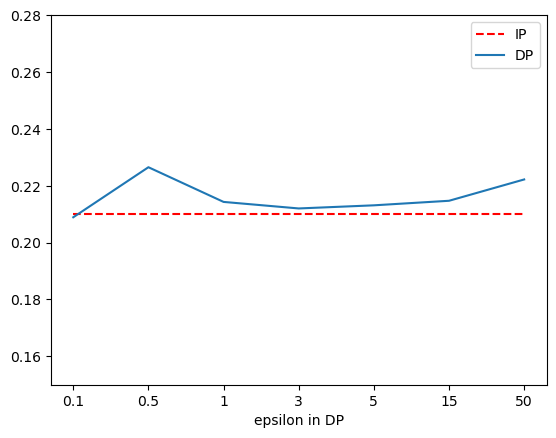

In [131]:
#here onwards plotting the acc_score for epsilon values and ip models acc_score has been calculate for say epsilon 3 ≈(noise_multiplier 0.65 in compute_sgd)
#plt.yticks([0.70, 0.75, 0.80, 0.90,0.95],["0.70","0.75","0.80","0.85","0.90"])
epsilon_list = ['0.1', '0.5', '1', '3', '5', '15', '50']

plt.ylim([0.15,0.28])

plt.xticks([0,1,2,3,4,5,6], epsilon_list)

acc_DP = [ 0.2089, 0.2265, 0.2143, 0.2120, 0.2131, 0.2147, 0.2222]
ipdd_acc=[0.2101]*len(acc_DP)
plt.plot(ipdd_acc, 'r--', label = "IP" )
plt.plot(acc_DP, label="DP")
plt.xlabel("epsilon in DP")
plt.legend()
plt.savefig("Insect_incremental DPvsOnlineIP.pdf",dpi=300, bbox_inches='tight')